# Monte Carlo and ARIMA Development

Fits are too good, don't believe it can actually predict this well. Don't use this for anything more than seeing how ARIMA works.

Stolen from some website that I need to find and then link to here for posterity

This is using the py37_benzene environment

In [1]:
import datetime # imports datetime for picking beginning and end dates for the analysis
import pandas as pd# imports pandas for dataframe manipulation
import numpy as np# imports numpy
import matplotlib as mpl# for data visualization
mpl.rcParams['figure.figsize'] = (25,8)# sets the plot size to 12x8
from matplotlib import pyplot as plt# for shorter lines with plotting
from statsmodels.tsa.stattools import adfuller  # Statistical test for stationary data
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from fitter import Fitter

import warnings # to hide warning messages
warnings.filterwarnings('ignore')


C:\Users\baanders\AppData\Local\Continuum\anaconda3\envs\py37_benzene\lib\site-packages\pkg_resources\__init__.py:119: PkgResourcesDeprecationWarning: 4.0.0-unsupported is an invalid version and will not be supported in a future release
  PkgResourcesDeprecationWarning,


In [2]:
dataroot = '../../Data/Parquet/'
ifilename = 'combined_ffill'
dfall = pd.read_parquet(dataroot+ifilename+'.parquet')
print(ifilename + ' dataset loaded with shape', dfall.shape, 'and', dfall.isna().sum().sum(), 'NaN values')

combined_ffill dataset loaded with shape (911, 153) and 64201 NaN values


In [3]:
[col for col in dfall if col.startswith('Benzene')]

['Benzene-Spot, Current Month, High-N/A-Cents per Gallon-FOB Houston, TX-North America',
 'Benzene-Spot, Current Month, Low-N/A-Cents per Gallon-FOB Houston, TX-North America',
 'Benzene-Spot, Next Month, High-N/A-Cents per Gallon-FOB Houston, TX-North America',
 'Benzene-Spot, Next Month, Low-N/A-Cents per Gallon-FOB Houston, TX-North America']

In [4]:
fit_col='Benzene-Spot, Current Month, High-N/A-Cents per Gallon-FOB Houston, TX-North America'

In [5]:
df = pd.DataFrame(dfall[fit_col]).dropna().rename(columns={fit_col:'data'})



In [6]:
print(df.describe(),'\n')
print(df.info())

              data
count   909.000000
mean   2073.106980
std     551.309139
min     222.630000
25%    1759.200000
50%    2078.000000
75%    2413.200000
max    4047.200000 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 909 entries, 2014-12-25 to 2022-03-11
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   data    909 non-null    float64
dtypes: float64(1)
memory usage: 14.2 KB
None


# ARIMA

<function matplotlib.pyplot.show(close=None, block=None)>

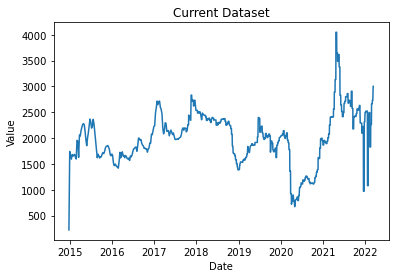

In [7]:
# grabs the last N observations, which will be reduced for the purpose of fitting a
# distribution for Monte Carlo simulation
df_resid_distr_fitting = df[-500:]
# creates a training subset missing the final N observations, which are being withheld
df_train = df[~df.data.isin(df_resid_distr_fitting)]
# grabs the final M observations for a test set
df_test = df_resid_distr_fitting[-250:]
# reduces the distribution fitting dataset to 50 observations
df_resid_distr_fitting = df_resid_distr_fitting[~df_resid_distr_fitting.isin(df_test).all(1)]

# plots the my_stock weekly closing price over the past 5 years
plt.plot(df.index, df.data)
plt.title('Current Dataset')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

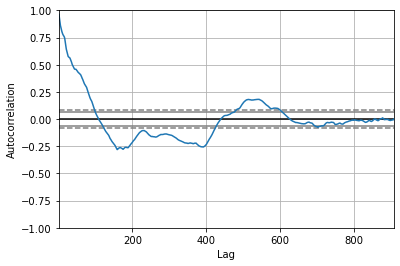

In [8]:
pd.plotting.autocorrelation_plot(df.data)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

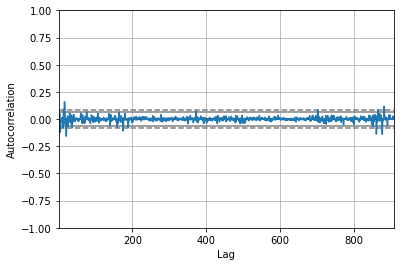

In [9]:
pd.plotting.autocorrelation_plot(df.data.diff().dropna())

In [10]:
for i in ['nc', 'c', 'ct']:
    result = adfuller(df.data, regression = i)
    print('ADF Statistic with %s for value: %f' % (i, result[0]))
    print('p-value: %f' % result[1])
    print('')

# performs ADF tests with no constant, a constant, and a constant plus linear trend on
# differenced NFLX closing share prices
for i in ['nc', 'c', 'ct']:
    result = adfuller(df.data.diff().dropna(), regression = i)
    print('ADF Statistic with %s for Differenced value: %f' % (i, result[0]))
    print('p-value: %f' % result[1])
    print('')

ADF Statistic with nc for value: -0.219883
p-value: 0.606516

ADF Statistic with c for value: -2.652365
p-value: 0.082650

ADF Statistic with ct for value: -2.845355
p-value: 0.180785

ADF Statistic with nc for Differenced value: -5.924677
p-value: 0.000000

ADF Statistic with c for Differenced value: -5.931684
p-value: 0.000000

ADF Statistic with ct for Differenced value: -5.932415
p-value: 0.000003



                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                  909
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 823.406
Date:                Thu, 17 Mar 2022   AIC                          -1640.813
Time:                        14:52:46   BIC                          -1626.379
Sample:                             0   HQIC                         -1635.301
                                - 909                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0171      3.256     -0.005      0.996      -6.399       6.365
ma.L1         -0.0172      3.253     -0.005      0.996      -6.392       6.358
sigma2         0.0095    7.7e-05    124.052      0.0

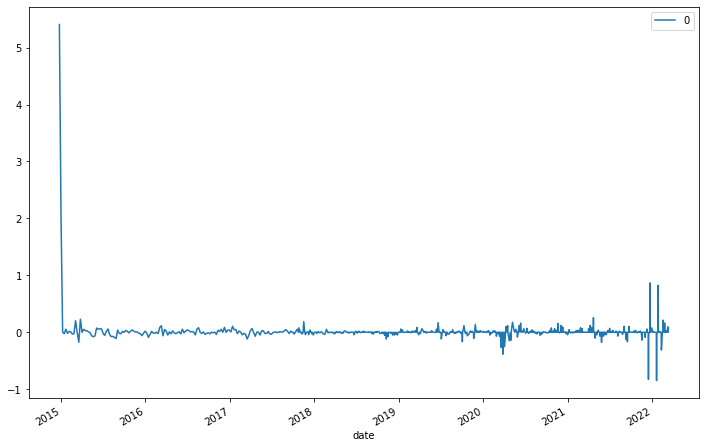

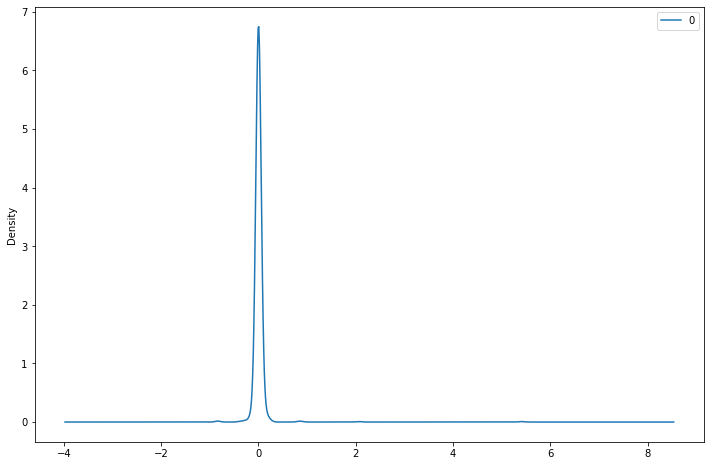

Descripiton of Residuals:
                   0
count  9.090000e+02
mean   8.908222e-03
std    2.040906e-01
min   -8.485132e-01
25%   -7.371218e-04
50%    5.540413e-08
75%    2.005073e-03
max    5.405511e+00


In [11]:
df_arima = ARIMA(np.log(df.data.astype(float)), order = (1, 1, 1))
df_arima_fit = df_arima.fit()
print(df_arima_fit.summary())

# sets the plot size to 12x8
mpl.rcParams['figure.figsize'] = (12,8)

# plot residual errors of the training data
residuals = pd.DataFrame(df_arima_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print("Descripiton of Residuals:\n" , residuals.describe())

Test MSE: 8370.022 
Test RMSE: 91.488


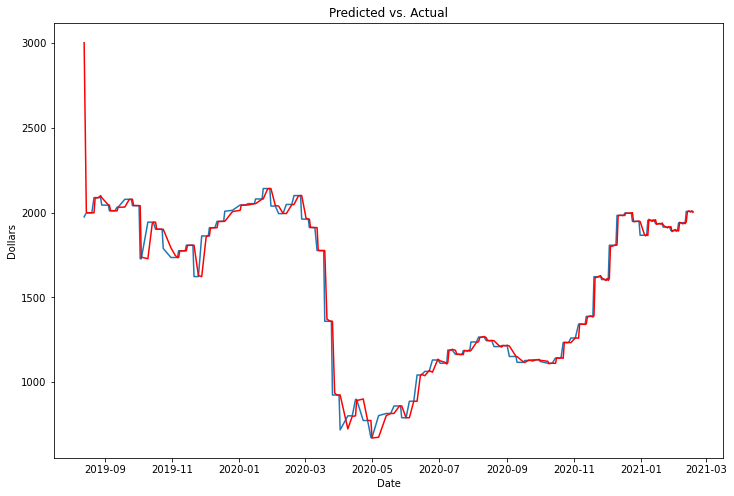

In [16]:
# creates a new dataframe that will be added to as the forecast rolls 
history = np.log(df.data.astype(float))
# creates an empty list that will hold predictions
predictions = []
# loops through the indexes of the set being forecased
for i in range(len(df_resid_distr_fitting)):
    # estimates an ARIMA model of order (1,1,1)
    model = ARIMA(history, order = (1,1,1))
    # fits the model
    model_fit = model.fit()
    # forecasts the next period
    output = model_fit.forecast()
    
    # takes the predicted value and saves it in yhat
    yhat = np.e ** output.iloc[0]
    #print(output.iloc[0], end='\r') # prints only a float value
    #print(yhat, end='\r') # Prints a single float value

    # appends yhat to the list of predictions
    predictions.append(yhat)
    #print(yhat, end='\r')
    # grabs the observation at the ith index
    obs = df_resid_distr_fitting[i : i + 1]
    #print(obs.astype(str) + " " + yhat.astype(str), end='\r')
    #obs.iloc[-1] = yhat # Replace next observation with current predicition. Predict the future as a random walk.
    #print(obs, end='\r')

    # appends the observation to the estimation data set
    history = history.append(np.log(obs.iloc[0].astype(float)))
    history.replace(history.iloc[-1], output.iloc[0])
    #print(history.iloc[-1], end='\r')
    

# prints the MSE and RMSE of the model for the rolling forecast period
error = mean_squared_error(df_resid_distr_fitting, predictions)
print('Test MSE: %.3f' % error, '\nTest RMSE: %.3f' % np.sqrt(error))

# converts the predictions list to a pandas dataframe with the same index as the actual values
# for plotting purposes
predictions = pd.DataFrame(predictions).rename(columns={0:'data'})
predictions.index = df_resid_distr_fitting.index

# sets the plot size to 12x8
mpl.rcParams['figure.figsize'] = (12,8)

# plots the predicted and actual stock prices 
plt.plot(df_resid_distr_fitting)
plt.plot(predictions, color = 'red')
plt.xlabel('Date')
plt.ylabel('Dollars')
plt.title('Predicted vs. Actual')
plt.show()

In [17]:
print(predictions.describe(), "\n")

print(df_resid_distr_fitting.describe(), "\n")

pred_res = predictions-df_resid_distr_fitting
print(pred_res.describe())

              data
count   250.000000
mean   1614.413972
std     429.129244
min     670.309262
25%    1196.804704
50%    1806.013628
75%    1957.692767
max    3001.431995 

             data
count   250.00000
mean   1610.18064
std     420.74643
min     672.80000
25%    1194.18000
50%    1807.04000
75%    1954.00000
max    2141.52000 

              data
count   250.000000
mean      4.233332
std      91.573157
min    -239.635616
25%      -3.577095
50%      -0.000457
75%       3.364417
max    1027.031995


<AxesSubplot:ylabel='Density'>

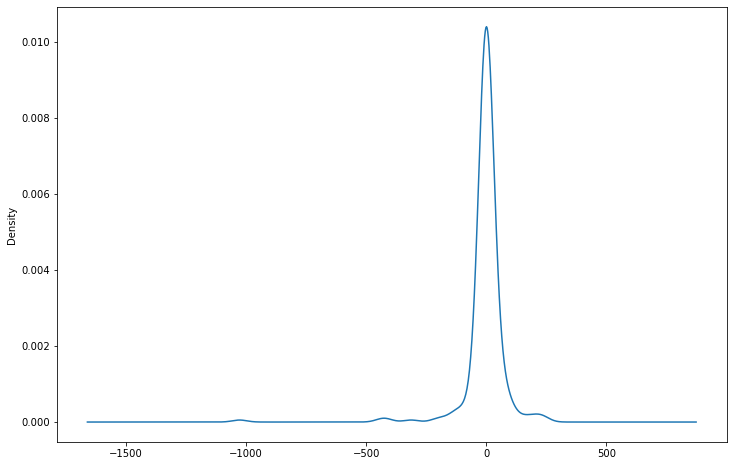

In [19]:
# to suppress warnings
warnings.filterwarnings('ignore')

# sets the plot size to 12x8
mpl.rcParams['figure.figsize'] = (12,8)

# plots the residuals using Kernel Density Estimation
tune_residuals = df_resid_distr_fitting.data - predictions.data
tune_residuals.plot(kind = 'kde')

In [20]:
tune_residuals.astype(float).describe()

count     250.000000
mean       -4.233332
std        91.573157
min     -1027.031995
25%        -3.364417
50%         0.000457
75%         3.577095
max       239.635616
Name: data, dtype: float64

In [21]:
#f = Fitter(tune_residuals)
#f.fit()
#f.summary()

KeyboardInterrupt: 

# Monte Carlo

In [22]:
# creates a function to do MC simulation with a Laplacian distribution
def laplace_monte_carlo(mean, residuals, n_sims):
    # gets the estimated beta or mean absolute distance from the mean
    beta = (sum(abs(residuals - np.mean(residuals))) 
                           / len(residuals))
    # uses the numpy function to generate an array of simulated values
    est_range = np.random.laplace(mean, beta, n_sims)
    # converts the array to a list
    est_range = list(est_range)
    # returns the simulated values
    return(est_range)

def roll_forecast_nmc(train, test, std_dev, n_sims):
    # creates a new dataframe that will be added to as the forecast rolls 
    history = np.log(train.astype(float))
    # creates an empty list that will hold predictions
    predictions = []
    # loops through the indexes of the set being forecased
    for i in range(len(test)):
        # estimates an ARIMA model of order (1,1,0)
        model = ARIMA(history, order = (1,1,1))
        # fits the model
        model_fit = model.fit()
        # forecasts the next period
        output = model_fit.forecast()
        # takes the predicted value and saves it in yhat
        yhat = np.e ** output.iloc[0]
        # performs monte carlo simulation using the predicted price as the mean, user-specified
        # standard deviation, and number of simulations
        yhat_range = laplace_monte_carlo(yhat, std_dev, n_sims)
        # appends yhat_range to the list of predictions
        predictions.append([float(i) for i in yhat_range])
        
        # grabs the observation at the ith index
        obs = test[i : i + 1]
        # To perform a random walk you need the prediciton as the next value in the sequence. Replace the obs to make this work.
        avg_pred = np.mean(yhat_range)
        obs.iloc[0] = avg_pred

        #print(avg_pred[-1:], end='\r')
        # appends the observation to the estimation data set
        history = history.append(np.log(obs.astype(float)))
        history.replace(history.iloc[-1], avg_pred)
        #history = history.append(np.log(avg_pred.astype(float)))

    # converts the predictions list to a pandas dataframe with the same index as the actual 
    # values for plotting purposes
    predictions = pd.DataFrame(predictions)
    predictions.index = df_resid_distr_fitting.index
    # converts all the estimated yhats in each column to one list per row
    predictions['predicted_range'] = predictions.values.tolist()
    # grabs only the column with all values in a list
    predictions = pd.DataFrame(predictions['predicted_range'])
        
    # returns predictions
    return(predictions)

In [23]:
# attaches the data withheld for investigating the forecast residuals back to the training
# data set to avoid a large error on the first forecast
df_train = df_train.append(df_resid_distr_fitting)


# produces a rolling forecast with prediction intervals using 1000 MC sims
test_preds = roll_forecast_nmc(df_train, 
                               df_test, 
                               tune_residuals,
                              10)

In [24]:
# creates an empty list
in_prediction_interval = []
# loops through the rows in the testing data set
for i in range(len(df_test)):
    # appends true if the actual price is in the interval of predicted prices and false
    # otherwise
    in_prediction_interval.append(np.where(min(test_preds.predicted_range[i]) <= 
                                           df_test.data[i]
                                          <= max(test_preds.predicted_range[i]), 
                                           True, False))
# prints the percentage of actual prices in the prediction intervals    
print('Percentage of Actual Values in Predicted Value Range: %f' % 
      (100 * sum(in_prediction_interval) / len(in_prediction_interval)))

Percentage of Actual Values in Predicted Value Range: 100.000000


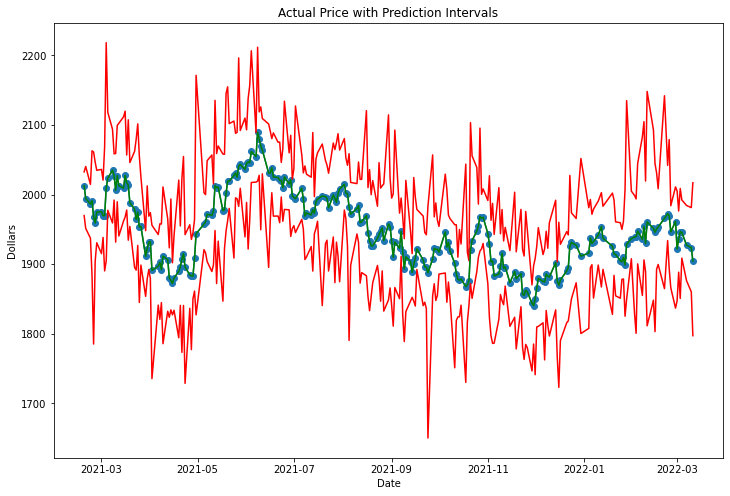

In [26]:
# creates empty lists to append to with minimum and maximum values for each weeks prediction
min_range = []
max_range = []
avg_range = []
std_range = []

# loops through the rows in test_preds
for i in range(len(test_preds)):
    # appends to the list the min or max value as appropriate
    min_range.append(min(test_preds.predicted_range[i]))
    max_range.append(max(test_preds.predicted_range[i]))
    avg_range.append(np.mean(test_preds.predicted_range[i]))
    std_range.append(np.std(test_preds.predicted_range[i]))

# converts the lists to data frames and makes their indexes match up with the dates they're
# predicting
min_range = pd.DataFrame(min_range)
min_range.index = df_test.index
max_range = pd.DataFrame(max_range)
max_range.index = df_test.index
avg_range = pd.DataFrame(avg_range)
avg_range.index = df_test.index
std_range = pd.DataFrame(std_range)
std_range.index = df_test.index

# plots the actual stock price with prediction intervals
#plt.plot(df_train, color = 'black')
plt.plot(df_test, marker='o')
plt.plot(min_range, color = 'red')
plt.plot(max_range, color = 'red')
plt.plot(avg_range, color = 'green')
plt.xlabel('Date')
plt.ylabel('Dollars')
plt.title('Actual Price with Prediction Intervals')
plt.show()